Useful links:

- [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

- [hugging face DETR](https://huggingface.co/docs/transformers/v4.33.2/en/model_doc/detr#transformers.DetrForObjectDetection)

- [PyTorch MAP](https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html)

In [34]:
import os
import time
from typing import List, Tuple
from collections import namedtuple
from bs4 import BeautifulSoup, element
from tqdm.notebook import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from torchmetrics.detection import MeanAveragePrecision

In [3]:
# Parse images and annots utils

Box = namedtuple('Box', 'xmin ymin xmax ymax')
VOCObject = namedtuple('VOCObject', 'cls xyxy')


def read_set(filepath: str) -> List[List[str]]:
    with open(filepath, 'r') as file:
        lines = file.readlines()
    return [line[:-1] for line in lines]


def read_xml(filepath: str) -> BeautifulSoup:
    with open(filepath, 'r') as xml_file:
        data = xml_file.read()
    return BeautifulSoup(data, 'xml')


def read_image_rgb(filepath: str) -> np.array:
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)


def parse_box_xyxy(annot_obj: element.Tag) -> Box:
    return Box(
        int(annot_obj.xmin.string),
        int(annot_obj.ymin.string),
        int(annot_obj.xmax.string),
        int(annot_obj.ymax.string),
    )


def parse_objects(annot: BeautifulSoup) -> List[VOCObject]:
    return [
        VOCObject(obj.find('name').string, parse_box_xyxy(obj))
        for obj in annot.find_all('object')
    ]

In [4]:
# Parse model results utils

def parse_to_voc_objects(model_res: dict, model_id2lbl: dict) -> List[VOCObject]:
    """
    model_res: dict results from processor.post_process_object_detection
    """
    labels = [model_id2lbl[lbl_id] for lbl_id in model_res['labels'].cpu().tolist()]
    boxes = [Box(*box.to(int).tolist()) for box in model_res['boxes'].cpu().detach()]
    return [VOCObject(cls, box) for cls, box in zip(labels, boxes)]


def draw_voc_objects(image: np.array, objects: List[VOCObject]) -> None:
    color = (0, 255, 255)
    image_draw = image.copy()
    for obj in objects:
        tl = (obj.xyxy.xmin, obj.xyxy.ymin)
        br = (obj.xyxy.xmax, obj.xyxy.ymax)        
        cv2.rectangle(image_draw, tl, br, color, 1)
        cv2.putText(
            image_draw, obj.cls, tl,
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 1, cv2.LINE_AA
        )
    plt.imshow(image_draw);

In [40]:
# Evaluate model utils

coco2voc = {
    'airplane': 'aeroplane',
    'bicycle': 'bicycle',
    'bird': 'bird',
    'boat': 'boat',
    'bottle': 'bottle',
    'bus': 'bus',
    'car': 'car',
    'cat': 'cat',
    'chair': 'chair',
    'cow': 'cow',
    'dining table': 'diningtable',
    'dog': 'dog',
    'horse': 'horse',
    'motorcycle': 'motorbike',
    'person': 'person',
    'potted plant': 'pottedplant',
    'sheep': 'sheep',
    'couch': 'sofa',
    'train': 'train',
    'tv': 'tvmonitor',
}

voc2_id2label = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor',
}

voc2_label2id = {lbl: i  for i, lbl in voc2_id2label.items()}


def cocolbl2voc(coco_lbl: int, model_id2lbl: dict) -> int:
    return voc2_label2id[coco2voc[model_id2lbl[coco_lbl]]]


def results2pred(results: dict, model_id2lbl: dict) -> dict:
    voc_lbls_mask = torch.tensor([
        model_id2lbl[lbl] in coco2voc.keys()
        for lbl in results['labels'].tolist()
    ])
    if voc_lbls_mask.any():
        return {
            'boxes': results['boxes'][voc_lbls_mask].detach(),
            'scores': results['scores'][voc_lbls_mask].detach(),
            'labels': torch.tensor([
                cocolbl2voc(lbl, model_id2lbl)
                for lbl in results['labels'][voc_lbls_mask].tolist()
            ]),
        }
    else:
        return {
            'boxes': torch.tensor([]).to(float),
            'scores': torch.tensor([]).to(float),
            'labels': torch.tensor([]),
        }


def voc_objects2target(voc_objects: List[VOCObject]) -> dict:
    gt_boxes, gt_labels = zip(*[
        (list(voc_obj.xyxy), voc2_label2id[voc_obj.cls])
        for voc_obj in voc_objects
    ])
    return {
        'boxes': torch.tensor(gt_boxes).to(float),
        'labels': torch.tensor(gt_labels)
    }


def filter_results(results: dict, model_id2lbl: dict):
    
    if voc_lbls_mask.any():
        return True, {
            'boxes': results['boxes'][voc_lbls_mask],
            'scores': results['scores'][voc_lbls_mask],
            'labels': results['labels'][voc_lbls_mask],
        }
    else:
        return False, None


def evaluate_over_voc(
    images_path: str,
    annots_path: str,
    val_images: List[str],
    model: torch.nn.Module,
    proc: DetrImageProcessor,
) -> Tuple[dict, float]:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    map = MeanAveragePrecision(iou_type='bbox')
    eval_time_sec = []
    for img_name in tqdm(val_images, total=len(val_images)):
    
        img_p = os.path.join(images_path, f'{img_name}.jpg')
        annot_p = os.path.join(annots_path, f'{img_name}.xml')
        val_img = read_image_rgb(img_p)
        val_annot = parse_objects(read_xml(annot_p))
        
        inputs = proc(images=val_img, return_tensors="pt").to(device)
        st = time.time()
        outputs = model(**inputs)
        et = time.time()
        eval_time_sec.append(et - st)
        target_sizes = torch.tensor([val_img.shape[:-1]])
        results = proc.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=0.9
        )[0]

        preds = [results2pred(results, model.config.id2label)]
        targets = [voc_objects2target(val_annot)]
        map.update(preds, targets)

    return map.compute(), round(sum(eval_time_sec) / len(eval_time_sec), 3)


def model_size(model):
    """
    Return model size in MB.
    """
    return sum(
        p.numel() * p.element_size()
        for p in model.parameters()
    ) / 1024**2

# Data

In [6]:
image_sets_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/ImageSets/Main/'
train_path = os.path.join(image_sets_path, 'train.txt')
val_path = os.path.join(image_sets_path, 'val.txt')

images_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/JPEGImages/'
annnots_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/Annotations/'

In [7]:
train_images = read_set(train_path)
val_images = read_set(val_path)

set(train_images) & set(val_images)

print(f'train: {len(train_images)}')
print(f'val: {len(val_images)}')

train: 5717
val: 5823


In [8]:
img_i = 238
img_p = os.path.join(images_path, f'{train_images[img_i]}.jpg')
annot_p = os.path.join(annnots_path, f'{train_images[img_i]}.xml')

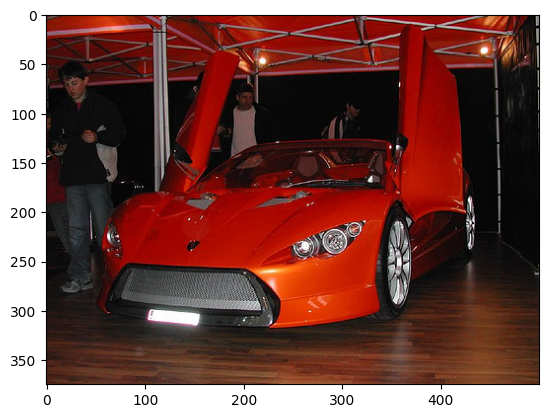

In [9]:
val_img = read_image_rgb(img_p)
plt.imshow(val_img)

# Model

In [10]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Ber

In [11]:
# model classes:
# model.config.id2label

In [12]:
inputs = processor(images=val_img, return_tensors="pt")

In [13]:
# model.to('cuda')

In [14]:
# inputs.to('cuda')

In [15]:
outputs = model(**inputs)
# torch.cuda.empty_cache()

In [16]:
target_sizes = torch.tensor([val_img.shape[:-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

In [17]:
results

{'scores': tensor([0.9959, 0.9980, 0.9994, 0.9897], grad_fn=<IndexBackward0>),
 'labels': tensor([1, 1, 1, 3]),
 'boxes': tensor([[282.4739,  88.4554, 321.6497, 128.0811],
         [176.1771,  71.0949, 237.6184, 147.5732],
         [  2.4599,  46.9724,  81.4834, 284.8432],
         [ 48.5924, 122.7702, 438.6585, 320.6874]], grad_fn=<IndexBackward0>)}

In [18]:
voc_objects = parse_to_voc_objects(results, model.config.id2label)

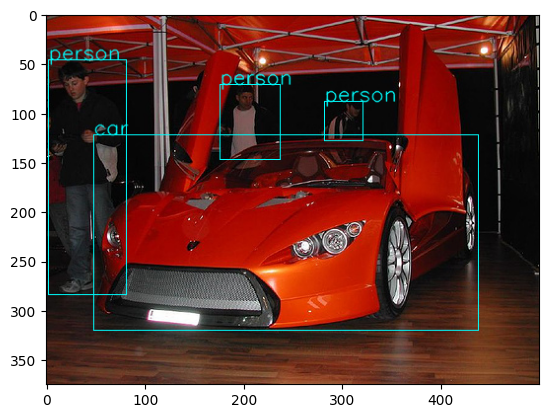

In [19]:
draw_voc_objects(val_img, voc_objects)

# Evaluation

In [45]:
res_map, mean_sec_per_frame = evaluate_over_voc(
    images_path=images_path,
    annots_path=annnots_path,
    val_images=val_images,
    model=model,
    proc=processor,
)

  0%|          | 0/5823 [00:00<?, ?it/s]

In [46]:
mean_sec_per_frame

0.086

In [47]:
res_map

{'map': tensor(0.5615),
 'map_50': tensor(0.7284),
 'map_75': tensor(0.6085),
 'map_small': tensor(0.1917),
 'map_medium': tensor(0.4111),
 'map_large': tensor(0.6620),
 'mar_1': tensor(0.4644),
 'mar_10': tensor(0.6254),
 'mar_100': tensor(0.6279),
 'mar_small': tensor(0.2522),
 'mar_medium': tensor(0.4811),
 'mar_large': tensor(0.7131),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19], dtype=torch.int32)}

In [42]:
print(f"Model size: {model_size(model):.3f} MB")

Model size: 158.404 MB
